In [32]:
%load_ext autoreload
%autoreload 2

import ollama
from router.utils import timer, time_function
import random
import numpy as np
import json

from router.embedding_router import generate_embeddings, return_top_k
from router.evals import recall_at_k, Evals

    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
TOOLS_JSON_PATH = "../data/tools.json"

with open(TOOLS_JSON_PATH, "r") as f:
    tools = json.load(f)

tools_flat_list = []
tools_map = []
tools_to_integration_map = {}
for category, tools in tools.items():
    for tool in tools:
        tools_flat_list.append(tool["description"])
        tools_map.append(tool["name"])
        tools_to_integration_map[tool["name"]] = category

print('Length of tools_flat_list', len(tools_flat_list))


Length of tools_flat_list 27


In [56]:
model_name = "mxbai-embed-large"
tools_embeddings = generate_embeddings(
    model_name=model_name,
    input_list=tools_flat_list
)

print(tools_embeddings.shape)

embeddings: 314.11ms
(27, 1024)


In [57]:
queries = evals.get_queries()

query_embeddings = generate_embeddings(
    model_name=model_name,
    input_list=queries
)
top_k = 10
top_k_indices, top_k_scores = return_top_k(tools_embeddings, query_embeddings, len(tools_flat_list))

predicted_integrations_list = []
predicted_tools_list = []

for q_idx, query in enumerate(queries):
    print(f"Query: {query}")
    predicted_integrations = []
    predicted_tools = []
    for k in range(len(tools_flat_list) - 1, -1, -1):
        tool_idx = top_k_indices[q_idx, k]
        tool = tools_flat_list[tool_idx]
        tool_name = tools_map[tool_idx]
        integration_name = tools_to_integration_map[tool_name]
        print(f"#{k}: Integration: {integration_name} Tool: {tool_name} Score: {top_k_scores[q_idx, k]}")
        predicted_integrations.append((integration_name, top_k_scores[q_idx, k]))
        predicted_tools.append((tool_name, top_k_scores[q_idx, k]))

    predicted_integrations_list.append(predicted_integrations,)
    predicted_tools_list.append(predicted_tools)

    print("-"*100)

embeddings: 87.01ms
Query: Play the Pink Panther theme song
#26: Integration: Music Tool: play_song Score: 0.6977960998896537
#25: Integration: Music Tool: search_library Score: 0.6133129319894132
#24: Integration: Notes Tool: create_note Score: 0.4889585128578947
#23: Integration: Slack Tool: send_message Score: 0.47608186038470957
#22: Integration: FaceTime Tool: start_call Score: 0.46705381923338096
#21: Integration: WebBrowser Tool: open_url Score: 0.4622734096575153
#20: Integration: Reminders Tool: create_reminder Score: 0.46169905579333076
#19: Integration: Maps Tool: get_directions Score: 0.45352349315046253
#18: Integration: System Tool: capture_screenshot Score: 0.44451626039451825
#17: Integration: Calendar Tool: create_event Score: 0.4407058504375327
#16: Integration: Calendar Tool: search_events Score: 0.4348010155978687
#15: Integration: Misc Tool: reply Score: 0.4341080009297308
#14: Integration: Calendar Tool: update_event Score: 0.42184795685170007
#13: Integration: Ma

In [ ]:
eval_data = evals.get_data()

def run_evals(queries, eval_data, predictions_list, top_k, score_threshold) -> tuple[float, float]:
    recall_at_k_list = []
    recall_at_k_integrations_list = []

    for q_idx, query in enumerate(queries):
        eval_instance = eval_data[q_idx]
        expected_integrations = eval_instance["integrations"]
        expected_tools = eval_instance["tools"]
        print(f"Query: {query}, length of expected tools: {len(expected_tools)}, length of expected integrations: {len(expected_integrations)}")
        predictions = predicted_tools_list[q_idx]
        r = recall_at_k(predictions, expected_tools, top_k, score_threshold)
        
        prediction_integrations = predicted_integrations_list[q_idx]
        r_integrations = recall_at_k(prediction_integrations, expected_integrations, top_k, score_threshold)
        recall_at_k_list.append(r)
        recall_at_k_integrations_list.append(r_integrations)

    return np.mean(recall_at_k_list).item(), np.mean(recall_at_k_integrations_list).item()

[[0.375, 0.375, 0.375, 0.375, 0.375], [0.375, 0.5, 0.5, 0.5, 0.5], [0.375, 0.5, 0.5, 0.75, 0.75], [0.375, 0.75, 0.75, 1.0, 1.0], [0.375, 0.75, 0.75, 1.0, 1.0], [0.375, 0.75, 0.75, 1.0, 1.0]]
[[0.375, 0.5, 0.5, 0.5, 0.5], [0.375, 0.5, 0.5, 0.5, 0.5], [0.375, 0.5, 0.5, 0.75, 0.75], [0.375, 0.75, 0.75, 1.0, 1.0], [0.375, 0.75, 0.75, 1.0, 1.0], [0.375, 0.75, 0.75, 1.0, 1.0]]


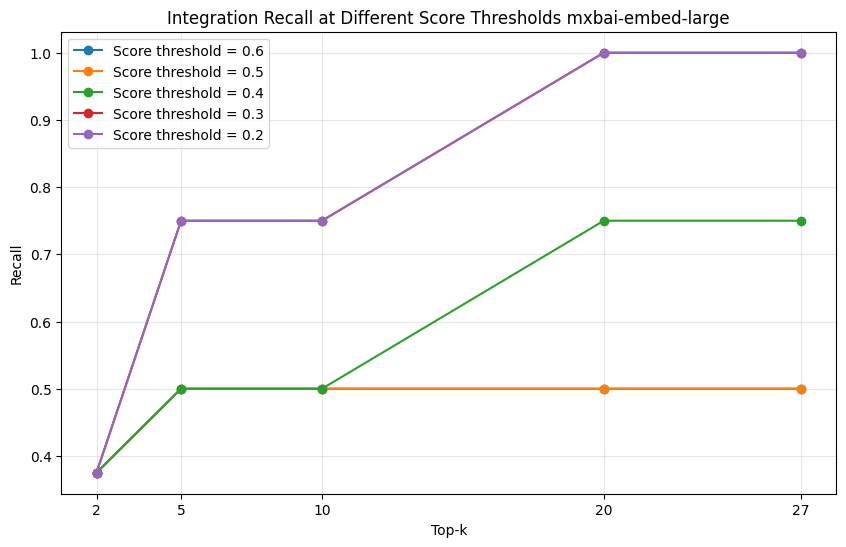